In [ ]:
# Introducción
#### 0.1.1 - 2025 - 09 - 01
#### Dr. Marco Aceves
#### rev en Jupyter Notebook
#### Código como ejemplo como parte del libro:
#### de 0 a 100 en Inteligencia Artificial
#### 7_Dimensionalidad

In [6]:
#Cargar las Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
class DimensionalityReductionComparison:
    """
    Clase para comparar diferentes técnicas de reducción de dimensionalidad
    """

    def __init__(self, dataset_name='wine'):
        """
        Inicializa con el dataset especificado

        Parameters:
        dataset_name (str): 'wine' o 'digits'
        """
        self.dataset_name = dataset_name
        self.load_data()
        self.results = {}

    def load_data(self):
        """Carga y prepara los datos"""
        if self.dataset_name == 'wine':
            data = load_wine()
            self.X = data.data
            self.y = data.target
            self.target_names = data.target_names
            self.feature_names = data.feature_names
        elif self.dataset_name == 'digits':
            data = load_digits()
            self.X = data.data
            self.y = data.target
            self.target_names = [str(i) for i in range(10)]
            self.feature_names = [f'pixel_{i}' for i in range(64)]

        # Normalización de datos
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)

        print(f"Dataset: {self.dataset_name}")
        print(f"Forma original: {self.X.shape}")
        print(f"Número de clases: {len(np.unique(self.y))}")
        print(f"Características: {len(self.feature_names)}")
        print("-" * 50)

    def apply_pca(self, n_components=2):
        """
        Aplica PCA para reducción de dimensionalidad

        Parameters:
        n_components (int): Número de componentes principales

        Returns:
        tuple: (datos_transformados, objeto_pca, tiempo_ejecución)
        """
        start_time = time.time()

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(self.X_scaled)

        execution_time = time.time() - start_time

        # Información sobre varianza explicada
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        print(f"PCA - Varianza explicada por componente: {explained_variance}")
        print(f"PCA - Varianza acumulada: {cumulative_variance[-1]:.4f}")
        print(f"PCA - Tiempo de ejecución: {execution_time:.4f} segundos")

        self.results['PCA'] = {
            'data': X_pca,
            'model': pca,
            'time': execution_time,
            'explained_variance': explained_variance
        }

        return X_pca, pca, execution_time

    def apply_lda(self, n_components=None):
        """
        Aplica LDA para reducción de dimensionalidad supervisada

        Parameters:
        n_components (int): Número de componentes discriminantes

        Returns:
        tuple: (datos_transformados, objeto_lda, tiempo_ejecución)
        """
        if n_components is None:
            n_components = min(len(np.unique(self.y)) - 1, 2)

        start_time = time.time()

        lda = LDA(n_components=n_components)
        X_lda = lda.fit_transform(self.X_scaled, self.y)

        execution_time = time.time() - start_time

        # Información sobre varianza explicada
        explained_variance = lda.explained_variance_ratio_

        print(f"LDA - Varianza explicada por componente: {explained_variance}")
        print(f"LDA - Tiempo de ejecución: {execution_time:.4f} segundos")

        self.results['LDA'] = {
            'data': X_lda,
            'model': lda,
            'time': execution_time,
            'explained_variance': explained_variance
        }

        return X_lda, lda, execution_time

    def apply_tsne(self, n_components=2, perplexity=30):
        """
        Aplica t-SNE para reducción de dimensionalidad no lineal

        Parameters:
        n_components (int): Número de dimensiones de salida
        perplexity (float): Parámetro de perplejidad

        Returns:
        tuple: (datos_transformados, objeto_tsne, tiempo_ejecución)
        """
        start_time = time.time()

        tsne = TSNE(
            n_components=n_components,
            perplexity=perplexity,
            random_state=42,
            n_iter=1000
        )
        X_tsne = tsne.fit_transform(self.X_scaled)

        execution_time = time.time() - start_time

        print(f"t-SNE - Perplejidad: {perplexity}")
        print(f"t-SNE - Tiempo de ejecución: {execution_time:.4f} segundos")

        self.results['t-SNE'] = {
            'data': X_tsne,
            'model': tsne,
            'time': execution_time
        }

        return X_tsne, tsne, execution_time

    def evaluate_classification_performance(self):
        """
        Evalúa el rendimiento de clasificación con y sin reducción de dimensionalidad
        """
        results = {}

        # Datos originales
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y, test_size=0.3, random_state=42, stratify=self.y
        )

        # Clasificador base
        clf = RandomForestClassifier(n_estimators=100, random_state=42)

        # Evaluación con datos originales
        start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        training_time = time.time() - start_time

        accuracy = accuracy_score(y_test, y_pred)
        results['Original'] = {
            'accuracy': accuracy,
            'training_time': training_time,
            'n_features': X_train.shape[1]
        }

        print(f"Datos originales - Precisión: {accuracy:.4f}, Tiempo: {training_time:.4f}s")

        # Evaluación con datos reducidos
        for method_name, method_data in self.results.items():
            if method_name == 't-SNE':
                continue  # t-SNE no es determinístico para nuevos datos

            X_reduced = method_data['data']
            X_train_red, X_test_red, _, _ = train_test_split(
                X_reduced, self.y, test_size=0.3, random_state=42, stratify=self.y
            )

            start_time = time.time()
            clf.fit(X_train_red, y_train)
            y_pred_red = clf.predict(X_test_red)
            training_time = time.time() - start_time

            accuracy = accuracy_score(y_test, y_pred_red)
            results[method_name] = {
                'accuracy': accuracy,
                'training_time': training_time,
                'n_features': X_reduced.shape[1]
            }

            print(f"{method_name} - Precisión: {accuracy:.4f}, Tiempo: {training_time:.4f}s")

        self.classification_results = results
        return results

    def plot_results(self, figsize=(15, 12)):
        """
        Visualiza los resultados de todas las técnicas de reducción

        Parameters:
        figsize (tuple): Tamaño de la figura
        """
        n_methods = len(self.results) + 1  # +1 para datos originales
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Comparación de Técnicas de Reducción de Dimensionalidad - Dataset: {self.dataset_name}',
                     fontsize=16, fontweight='bold')

        # Colores para cada clase
        colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(self.y))))

        # Plot 1: PCA
        if 'PCA' in self.results:
            axes[0, 0].scatter(self.results['PCA']['data'][:, 0],
                             self.results['PCA']['data'][:, 1],
                             c=self.y, cmap='Set3', alpha=0.7)
            axes[0, 0].set_title(f'PCA (Var. Explicada: {sum(self.results["PCA"]["explained_variance"]):.3f})')
            axes[0, 0].set_xlabel('Componente Principal 1')
            axes[0, 0].set_ylabel('Componente Principal 2')
            axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: LDA
        if 'LDA' in self.results:
            if self.results['LDA']['data'].shape[1] == 1:
                # Si LDA solo tiene 1 componente, usar scatter plot 1D
                axes[0, 1].scatter(self.results['LDA']['data'][:, 0],
                                 np.zeros_like(self.results['LDA']['data'][:, 0]),
                                 c=self.y, cmap='Set3', alpha=0.7)
                axes[0, 1].set_xlabel('Discriminante Lineal 1')
                axes[0, 1].set_ylabel('')
            else:
                axes[0, 1].scatter(self.results['LDA']['data'][:, 0],
                                 self.results['LDA']['data'][:, 1],
                                 c=self.y, cmap='Set3', alpha=0.7)
                axes[0, 1].set_xlabel('Discriminante Lineal 1')
                axes[0, 1].set_ylabel('Discriminante Lineal 2')

            axes[0, 1].set_title(f'LDA (Var. Explicada: {sum(self.results["LDA"]["explained_variance"]):.3f})')
            axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: t-SNE
        if 't-SNE' in self.results:
            axes[1, 0].scatter(self.results['t-SNE']['data'][:, 0],
                             self.results['t-SNE']['data'][:, 1],
                             c=self.y, cmap='Set3', alpha=0.7)
            axes[1, 0].set_title('t-SNE')
            axes[1, 0].set_xlabel('t-SNE 1')
            axes[1, 0].set_ylabel('t-SNE 2')
            axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Comparación de rendimiento
        if hasattr(self, 'classification_results'):
            methods = list(self.classification_results.keys())
            accuracies = [self.classification_results[m]['accuracy'] for m in methods]
            times = [self.classification_results[m]['training_time'] for m in methods]

            x_pos = np.arange(len(methods))

            # Crear gráfico de barras doble
            ax4 = axes[1, 1]
            ax4_twin = ax4.twinx()

            bars1 = ax4.bar(x_pos - 0.2, accuracies, 0.4, label='Precisión', alpha=0.8, color='skyblue')
            bars2 = ax4_twin.bar(x_pos + 0.2, times, 0.4, label='Tiempo (s)', alpha=0.8, color='lightcoral')

            ax4.set_xlabel('Método')
            ax4.set_ylabel('Precisión', color='blue')
            ax4_twin.set_ylabel('Tiempo de entrenamiento (s)', color='red')
            ax4.set_title('Rendimiento de Clasificación')
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(methods, rotation=45)
            ax4.grid(True, alpha=0.3)

            # Añadir valores en las barras
            for bar, acc in zip(bars1, accuracies):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()

    def plot_explained_variance(self):
        """
        Visualiza la varianza explicada para PCA
        """
        if 'PCA' not in self.results:
            print("Debe ejecutar PCA primero")
            return

        # Calcular PCA con más componentes para el gráfico de varianza
        pca_full = PCA()
        pca_full.fit(self.X_scaled)

        explained_variance = pca_full.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        plt.figure(figsize=(12, 5))

        # Gráfico de varianza explicada individual
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
        plt.xlabel('Componente Principal')
        plt.ylabel('Varianza Explicada')
        plt.title('Varianza Explicada por Componente')
        plt.grid(True, alpha=0.3)

        # Gráfico de varianza acumulada
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza')
        plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Varianza')
        plt.xlabel('Número de Componentes')
        plt.ylabel('Varianza Acumulada')
        plt.title('Varianza Acumulada')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Encontrar número de componentes para 95% y 90% de varianza
        n_95 = np.argmax(cumulative_variance >= 0.95) + 1
        n_90 = np.argmax(cumulative_variance >= 0.90) + 1

        print(f"Componentes necesarios para 90% de varianza: {n_90}")
        print(f"Componentes necesarios para 95% de varianza: {n_95}")

    def generate_summary_report(self):
        """
        Genera un reporte resumido de todas las técnicas aplicadas
        """
        print("\n" + "="*60)
        print("REPORTE RESUMEN - REDUCCIÓN DE DIMENSIONALIDAD")
        print("="*60)

        print(f"\nDataset: {self.dataset_name}")
        print(f"Dimensiones originales: {self.X.shape}")
        print(f"Número de clases: {len(np.unique(self.y))}")

        print(f"\n{'Método':<15} {'Tiempo (s)':<12} {'Dim. Final':<12} {'Precisión':<12}")
        print("-" * 55)

        # Resultados de clasificación
        if hasattr(self, 'classification_results'):
            for method, results in self.classification_results.items():
                print(f"{method:<15} {results['training_time']:<12.4f} "
                      f"{results['n_features']:<12} {results['accuracy']:<12.4f}")

        print(f"\n{'Método':<15} {'Reducción (%)':<15} {'Var. Explicada':<15}")
        print("-" * 50)

        original_dims = self.X.shape[1]
        for method, results in self.results.items():
            if method == 't-SNE':
                reduction = (1 - 2/original_dims) * 100
                var_explained = "N/A"
            else:
                final_dims = results['data'].shape[1]
                reduction = (1 - final_dims/original_dims) * 100
                var_explained = f"{sum(results['explained_variance']):.3f}"

            print(f"{method:<15} {reduction:<15.1f} {var_explained:<15}")

COMPARACIÓN DE TÉCNICAS DE REDUCCIÓN DE DIMENSIONALIDAD
Dataset: wine
Forma original: (178, 13)
Número de clases: 3
Características: 13
--------------------------------------------------

1. Aplicando PCA...
PCA - Varianza explicada por componente: [0.36198848 0.1920749 ]
PCA - Varianza acumulada: 0.5541
PCA - Tiempo de ejecución: 0.0014 segundos

2. Aplicando LDA...
LDA - Varianza explicada por componente: [0.68747889 0.31252111]
LDA - Tiempo de ejecución: 0.0026 segundos

3. Aplicando t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE - Perplejidad: 30
t-SNE - Tiempo de ejecución: 0.9213 segundos

4. Evaluando rendimiento de clasificación...
Datos originales - Precisión: 1.0000, Tiempo: 0.1662s
PCA - Precisión: 0.9259, Tiempo: 0.1600s
LDA - Precisión: 0.9815, Tiempo: 0.1615s

5. Generando visualizaciones...


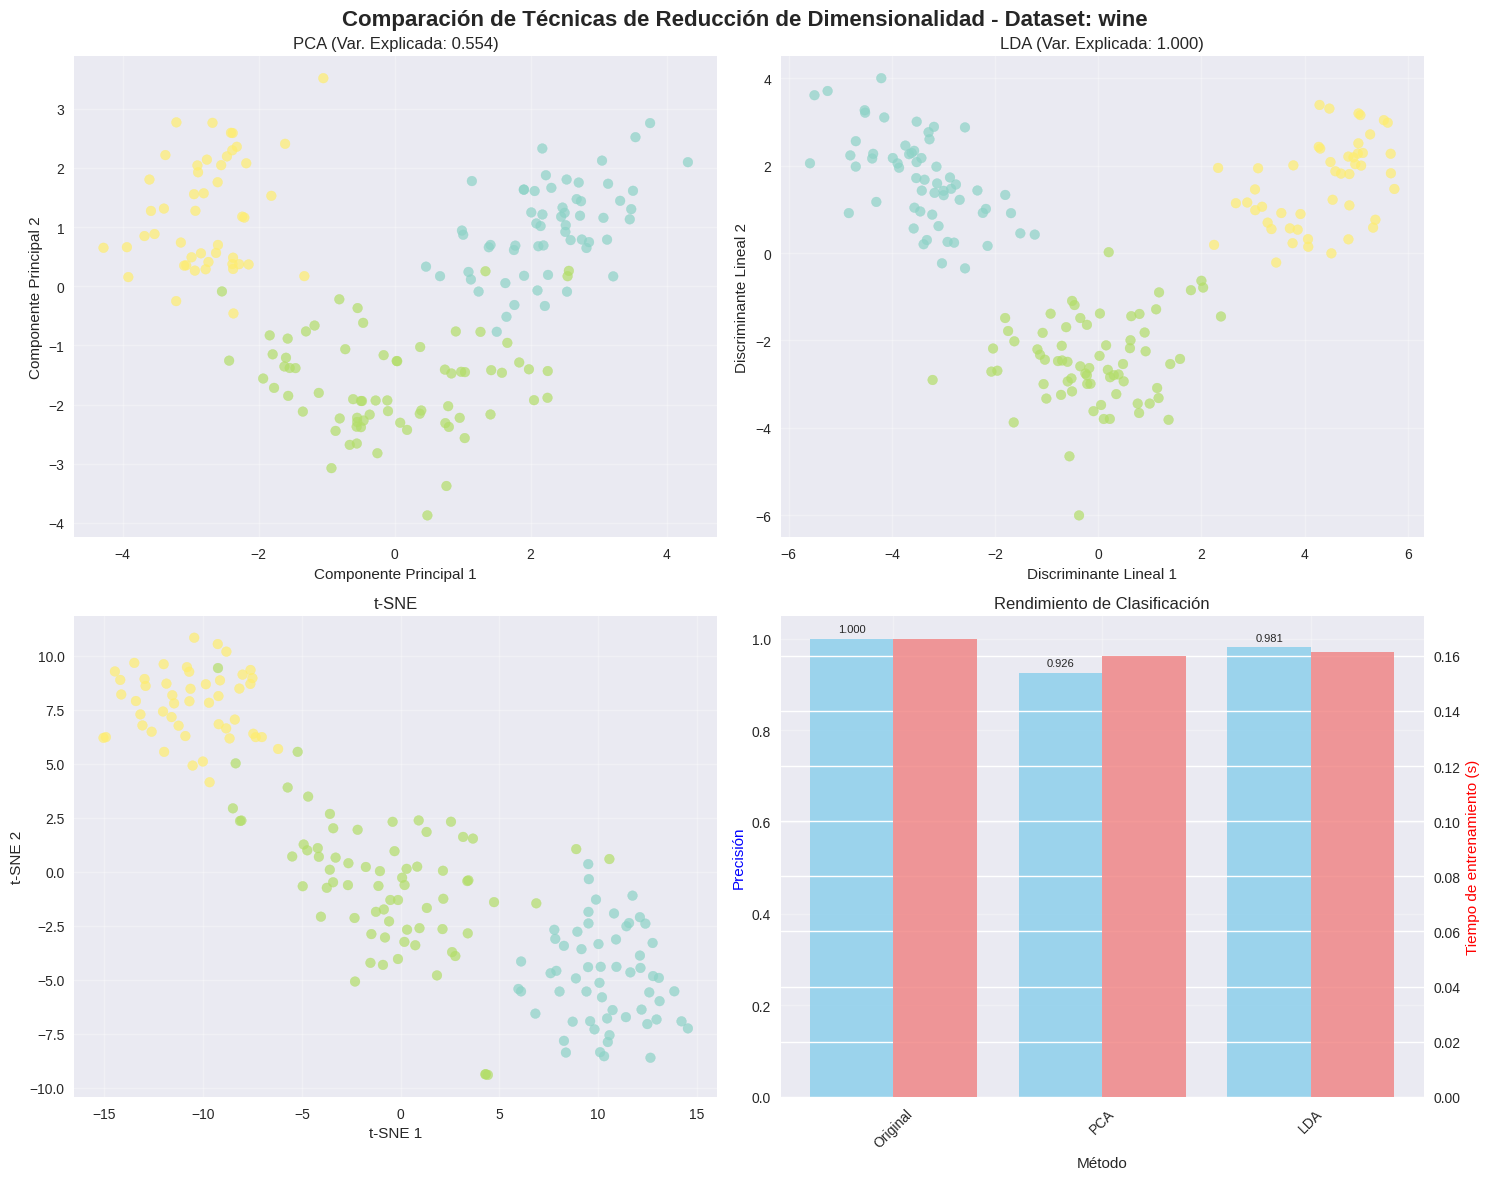


6. Analizando varianza explicada...


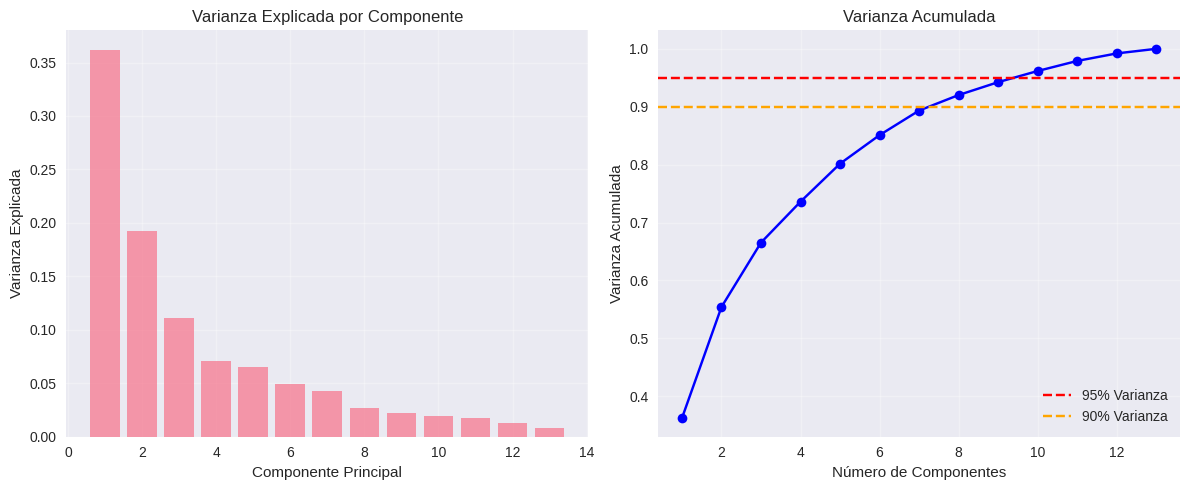

Componentes necesarios para 90% de varianza: 8
Componentes necesarios para 95% de varianza: 10

7. Generando reporte final...

REPORTE RESUMEN - REDUCCIÓN DE DIMENSIONALIDAD

Dataset: wine
Dimensiones originales: (178, 13)
Número de clases: 3

Método          Tiempo (s)   Dim. Final   Precisión   
-------------------------------------------------------
Original        0.1662       13           1.0000      
PCA             0.1600       2            0.9259      
LDA             0.1615       2            0.9815      

Método          Reducción (%)   Var. Explicada 
--------------------------------------------------
PCA             84.6            0.554          
LDA             84.6            1.000          
t-SNE           84.6            N/A            

CONCLUSIONES Y RECOMENDACIONES:

    1. PCA: Mejor para análisis exploratorio y cuando necesitas interpretabilidad
       - Preserva la máxima varianza
       - Computacionalmente eficiente
       - Componentes son combinaciones lineal

In [8]:
# Ejemplo de uso completo
def main():
    """
    Función principal que ejecuta toda la comparación
    """
    print("COMPARACIÓN DE TÉCNICAS DE REDUCCIÓN DE DIMENSIONALIDAD")
    print("=" * 60)

    # Crear instancia con dataset de vinos
    reducer = DimensionalityReductionComparison('wine')

    print("\n1. Aplicando PCA...")
    reducer.apply_pca(n_components=2)

    print("\n2. Aplicando LDA...")
    reducer.apply_lda()

    print("\n3. Aplicando t-SNE...")
    reducer.apply_tsne(perplexity=30)

    print("\n4. Evaluando rendimiento de clasificación...")
    reducer.evaluate_classification_performance()

    print("\n5. Generando visualizaciones...")
    reducer.plot_results()

    print("\n6. Analizando varianza explicada...")
    reducer.plot_explained_variance()

    print("\n7. Generando reporte final...")
    reducer.generate_summary_report()

    return reducer

# Ejecutar ejemplo
if __name__ == "__main__":
    # Ejemplo básico
    comparison = main()

    print("\n" + "="*60)
    print("CONCLUSIONES Y RECOMENDACIONES:")
    print("="*60)
    print("""
    1. PCA: Mejor para análisis exploratorio y cuando necesitas interpretabilidad
       - Preserva la máxima varianza
       - Computacionalmente eficiente
       - Componentes son combinaciones lineales interpretables

    2. LDA: Ideal para problemas de clasificación supervisada
       - Maximiza separación entre clases
       - Requiere etiquetas de clase
       - Número máximo de componentes: n_clases - 1

    3. t-SNE: Excelente para visualización de estructuras no lineales
       - Preserva relaciones locales
       - Computacionalmente costoso
       - No determinístico (resultados pueden variar)

    RECOMENDACIÓN:
    - Para análisis inicial: usar PCA
    - Para clasificación: probar LDA si es supervisado
    - Para visualización final: usar t-SNE
    - Para producción: evaluar trade-off precisión vs. velocidad
    """)